<a href="https://colab.research.google.com/github/adetunjipeter02/Hello-World/blob/master/Facial_Expression_Prediction_using_Mixed_CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download msambare/fer2013

 99% 60.0M/60.3M [00:00<00:00, 108MB/s] 
100% 60.3M/60.3M [00:00<00:00, 92.3MB/s]


In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
import tensorflow as tf
from PIL import Image
from google.colab.patches import cv2_imshow
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import itertools

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True,rotation_range = 30)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 48
IMG_WIDTH = 48

train_dir = 'train'
test_dir = 'test'

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=test_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))
final_test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=test_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Dataset

In [ ]:
labels = train_data_gen.class_indices
train_no = {}
test_no = {}

In [ ]:
for f in os.listdir(train_dir):
  train_no[f] = len(os.listdir(os.path.join(train_dir, f)))

for f in os.listdir(test_dir):
  test_no[f] = len(os.listdir(os.path.join(test_dir, f)))

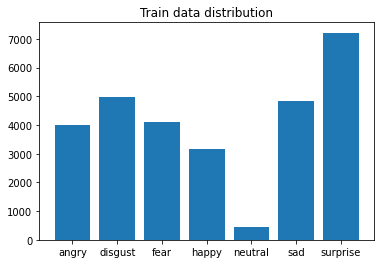

In [ ]:
plt.bar(labels.keys(), train_no.values())
plt.title('Train data distribution')
plt.savefig('train distribution.png')

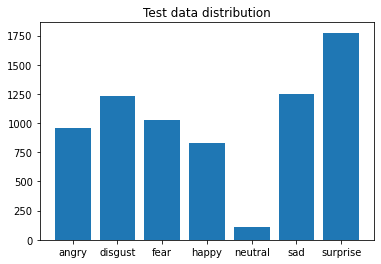

In [ ]:
plt.bar(labels.keys(), test_no.values())
plt.title('Test data distribution')
plt.savefig('test distribution.png')

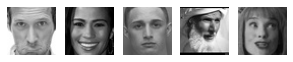

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(5,len(images_arr) * 3))
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    

sample_training_images, _ = next(img_gen)
plotImages(sample_training_images[:5])


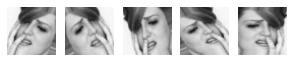

In [ ]:
aug_training_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(aug_training_images)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.style.use('seaborn-darkgrid')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)

# LIGHT WEIGHT 

In [ ]:
model = tf.keras.Sequential([
    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(32, (5, 5), activation="relu", input_shape=(IMG_WIDTH, IMG_WIDTH, 3)),

    # Max-pooling layer, using 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (7, 7), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax")])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        100416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 2304)              0

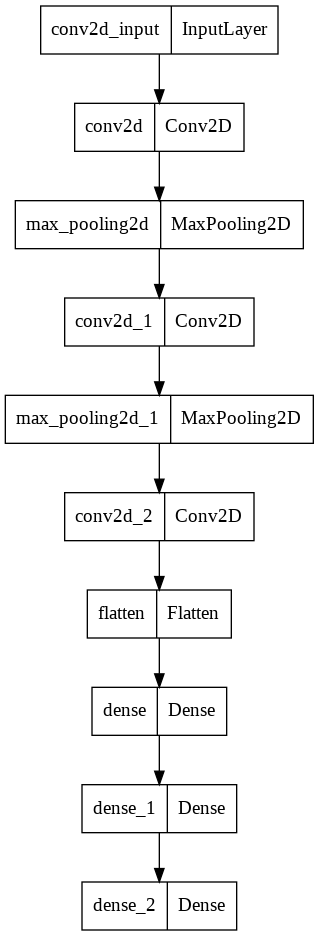

In [ ]:
tf.keras.utils.plot_model(model, to_file = 'lw.png')

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/nlw/save{epoch:02d}.h5',period=10,save_weights_only=False)

In [ ]:
lw_history = model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 60)

Epoch 1/60
225/225 [==============================] - 57s 200ms/step - loss: 1.8184 - accuracy: 0.2469 - val_loss: 1.7594 - val_accuracy: 0.2764
Epoch 2/60
225/225 [==============================] - 35s 156ms/step - loss: 1.7081 - accuracy: 0.3144 - val_loss: 1.6054 - val_accuracy: 0.3617
Epoch 3/60
225/225 [==============================] - 36s 159ms/step - loss: 1.6059 - accuracy: 0.3703 - val_loss: 1.4864 - val_accuracy: 0.4250
Epoch 4/60
225/225 [==============================] - 33s 148ms/step - loss: 1.5281 - accuracy: 0.4033 - val_loss: 1.4333 - val_accuracy: 0.4458
Epoch 5/60
225/225 [==============================] - 34s 153ms/step - loss: 1.4850 - accuracy: 0.4233 - val_loss: 1.3881 - val_accuracy: 0.4709
Epoch 6/60
225/225 [==============================] - 35s 154ms/step - loss: 1.4400 - accuracy: 0.4469 - val_loss: 1.3691 - val_accuracy: 0.4792
Epoch 7/60
225/225 [==============================] - 37s 165ms/step - loss: 1.4076 - accuracy: 0.4586 - val_loss: 1.3531 - val_ac

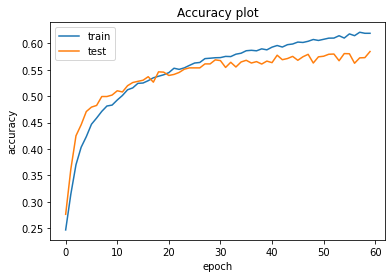

In [ ]:
import matplotlib.pyplot as plt
hist = lw_history.history

plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("lightweightmodel_accuracy.png")

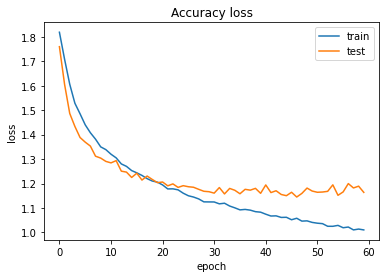

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("lightweightmodel_loss.png")

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/peter/final/lw/save.h5')

In [ ]:
model.evaluate(final_test_data_gen)
labels = test_data_gen.class_indices

57/57 [==============================] - 12s 34ms/step - loss: 1.1686 - accuracy: 0.5674


Confusion matrix, without normalization
[[161   9  69 235 186 139 159]
 [ 21   0   9  28  18  16  19]
 [152   9  71 274 212 158 148]
 [289  24 121 458 384 280 218]
 [191  14 101 303 261 191 172]
 [193  12  91 321 264 211 155]
 [145   6  58 206 162 138 116]]


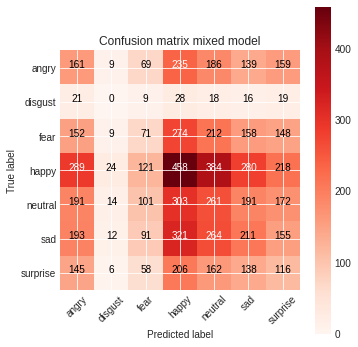

In [ ]:
predictions = model.predict(test_data_gen)
predictions = tf.argmax(predictions, axis = 1).numpy()
cm = confusion_matrix(test_data_gen.classes, predictions)
plot_confusion_matrix(cm, labels.keys(),
                        normalize=False,
                        title='Confusion matrix mixed model',
                        cmap='Reds')

# VGG MODEL

## Pre-trained

In [ ]:
pretrained_vgg19_base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(48, 48, 3),
    include_top=False)
pretrained_vgg19_base_model.trainable = False

inputs = tf.keras.Input(shape=(48, 48, 3))
inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
x = pretrained_vgg19_base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(7)(x)
outputs = tf.keras.layers.Activation('softmax')(x)
pretrained_vgg19_model = tf.keras.Model(inputs, outputs)

pretrained_vgg19_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/vgg19/save{epoch:02d}.h5',period=10,save_weights_only=False)

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/vgg19/save{epoch:02d}.h5',period=10,save_weights_only=False)
p_vgg_history = pretrained_vgg19_model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 15)

Epoch 1/15
225/225 [==============================] - 49s 167ms/step - loss: 1.7122 - accuracy: 0.3083 - val_loss: 1.6389 - val_accuracy: 0.3422
Epoch 2/15
225/225 [==============================] - 36s 161ms/step - loss: 1.6567 - accuracy: 0.3374 - val_loss: 1.6121 - val_accuracy: 0.3564
Epoch 3/15
225/225 [==============================] - 36s 161ms/step - loss: 1.6385 - accuracy: 0.3473 - val_loss: 1.5985 - val_accuracy: 0.3632
Epoch 4/15
225/225 [==============================] - 35s 155ms/step - loss: 1.6296 - accuracy: 0.3545 - val_loss: 1.6056 - val_accuracy: 0.3586
Epoch 5/15
225/225 [==============================] - 35s 155ms/step - loss: 1.6187 - accuracy: 0.3586 - val_loss: 1.5899 - val_accuracy: 0.3716
Epoch 6/15
225/225 [==============================] - 36s 161ms/step - loss: 1.6075 - accuracy: 0.3654 - val_loss: 1.5937 - val_accuracy: 0.3731
Epoch 7/15
225/225 [==============================] - 35s 156ms/step - loss: 1.6081 - accuracy: 0.3668 - val_loss: 1.5896 - val_ac

In [ ]:
pretrained_vgg19_base_model.trainable = True
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/vgg192/save{epoch:02d}.h5',period=10,save_weights_only=False)

pretrained_vgg19_model.summary()
pretrained_vgg19_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

p_vgg_history2 = pretrained_vgg19_model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 15)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 activation (Activation)     (None, 128)               0         
                                                             

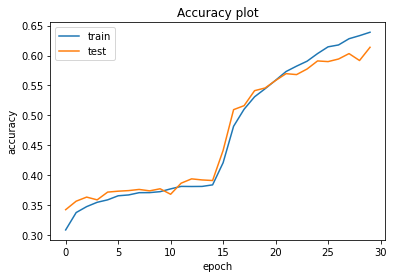

In [ ]:
p_vgg_hist = p_vgg_history.history
p_vgg_hist2 = p_vgg_history2.history

plt.plot(p_vgg_hist["accuracy"] + p_vgg_hist2['accuracy'])
plt.plot(p_vgg_hist["val_accuracy"] + p_vgg_hist2['val_accuracy'])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("pretrained_vgg_model_accuracy.png")

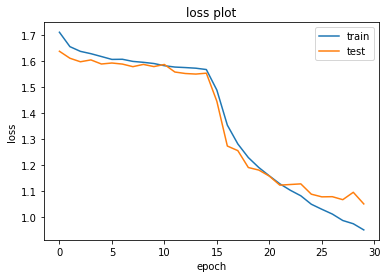

In [ ]:
plt.plot(p_vgg_hist["loss"] + p_vgg_hist2['loss'])
plt.plot(p_vgg_hist["val_loss"] + p_vgg_hist2['val_loss'])
plt.title("loss plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("pretrained_vgg_model_loss.png")

Confusion matrix, without normalization
[[134  15  86 258 204 162  99]
 [ 21   2   5  24  20  20  19]
 [150  11  94 245 237 173 114]
 [267  14 172 428 398 292 203]
 [172  11 126 308 281 208 127]
 [226  11 109 302 267 202 130]
 [108   6  82 207 191 146  91]]


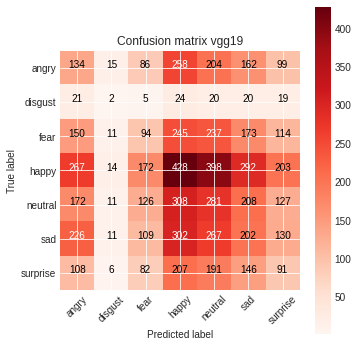

In [ ]:
predictions = pretrained_vgg19_model.predict(test_data_gen)
predictions = tf.argmax(predictions, axis = 1).numpy()
cm = confusion_matrix(test_data_gen.classes, predictions)
plot_confusion_matrix(cm, labels.keys(),
                        normalize=False,
                        title='Confusion matrix vgg19',
                        cmap='Reds')

# RESNET

## Pre-trained

In [ ]:
pretrained_resnet_base = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(48, 48, 3),
    include_top=False)

pretrained_resnet_base.trainable = False

inputs = tf.keras.Input(shape=(48, 48, 3))
inputs = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = pretrained_resnet_base(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(7)(x)
outputs = tf.keras.layers.Activation('softmax')(x)
pretrained_resnet_model = tf.keras.Model(inputs, outputs)

pretrained_resnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/resnet/save{epoch:02d}.h5',period=10,save_weights_only=False)

In [ ]:
p_resnet_history = pretrained_resnet_model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 15)

Epoch 1/15
225/225 [==============================] - 43s 173ms/step - loss: 1.7559 - accuracy: 0.3132 - val_loss: 1.6446 - val_accuracy: 0.3632
Epoch 2/15
225/225 [==============================] - 37s 163ms/step - loss: 1.6392 - accuracy: 0.3516 - val_loss: 1.6072 - val_accuracy: 0.3722
Epoch 3/15
225/225 [==============================] - 38s 168ms/step - loss: 1.6183 - accuracy: 0.3627 - val_loss: 1.5764 - val_accuracy: 0.3828
Epoch 4/15
225/225 [==============================] - 44s 194ms/step - loss: 1.6016 - accuracy: 0.3716 - val_loss: 1.5744 - val_accuracy: 0.3899
Epoch 5/15
225/225 [==============================] - 35s 154ms/step - loss: 1.5881 - accuracy: 0.3745 - val_loss: 1.5765 - val_accuracy: 0.3867
Epoch 6/15
225/225 [==============================] - 36s 160ms/step - loss: 1.5846 - accuracy: 0.3796 - val_loss: 1.5589 - val_accuracy: 0.3943
Epoch 7/15
225/225 [==============================] - 37s 162ms/step - loss: 1.5766 - accuracy: 0.3833 - val_loss: 1.5449 - val_ac

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/resnet2/save{epoch:02d}.h5',period=10,save_weights_only=False)
pretrained_resnet_base.trainable = True

pretrained_resnet_model.summary()
pretrained_resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

p_resnet_history2 = pretrained_resnet_model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 15)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                           

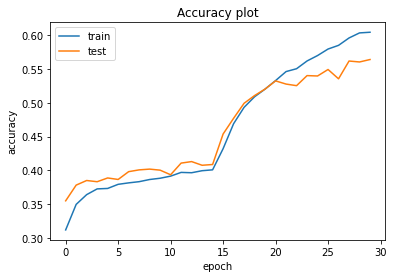

In [ ]:
p_resnet_hist = p_resnet_history.history
p_resnet_hist2 = p_resnet_history2.history

plt.plot(p_resnet_hist["accuracy"] + p_resnet_hist2['accuracy'])
plt.plot(p_resnet_hist["val_accuracy"] + p_resnet_hist2['val_accuracy'])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("pretrained_resnet_model_accuracy.png")

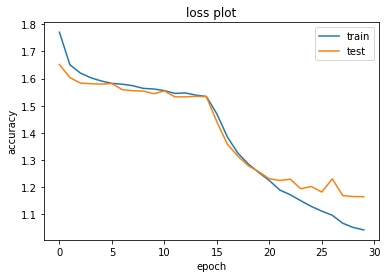

In [ ]:
p_resnet_hist = p_resnet_history.history
p_resnet_hist2 = p_resnet_history2.history

plt.plot(p_resnet_hist["loss"] + p_resnet_hist2['loss'])
plt.plot(p_resnet_hist["val_loss"] + p_resnet_hist2['val_loss'])
plt.title("loss plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("pretrained_resnet_model_loss.png")

Confusion matrix, without normalization
[[110   6  90 255 217 149 131]
 [ 13   1   8  20  30  22  17]
 [127   8 115 254 239 156 125]
 [240  10 182 460 368 277 237]
 [145   3 126 359 291 168 141]
 [148  14 142 318 300 191 134]
 [115   5  87 237 180 104 103]]


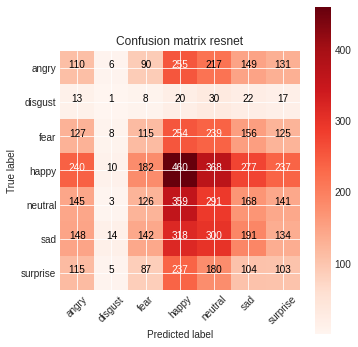

In [ ]:
predictions = pretrained_resnet_model.predict(test_data_gen)
predictions = tf.argmax(predictions, axis = 1).numpy()
cm = confusion_matrix(test_data_gen.classes, predictions)
plot_confusion_matrix(cm, labels.keys(),
                        normalize=False,
                        title='Confusion matrix resnet',
                        cmap='Reds')

In [ ]:
print(f1_score(test_data_gen.classes, predictions, average = 'micro'))
print(f1_score(test_data_gen.classes, predictions, average = 'macro'))
print(f1_score(test_data_gen.classes, predictions, average = 'weighted'))

0.1770688213987183
0.1428007600563388
0.17388044959253265


## Random initialization

In [ ]:
resnet_base = tf.keras.applications.ResNet50V2(
    weights=None,
    input_shape=(48, 48, 3),
    include_top=False)

inputs = tf.keras.Input(shape=(48, 48, 3))
inputs = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = resnet_base(inputs, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(7)(x)
outputs = tf.keras.layers.Activation('softmax')(x)
resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# CNN-RNN MODEL

## Light weight

In [ ]:
mixed_model = tf.keras.Sequential([
    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(32, (5, 5), activation="relu", input_shape=(IMG_WIDTH, IMG_WIDTH, 3)),

    # Max-pooling layer, using 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Reshape((-1, 22, 22, 32)),
    tf.keras.layers.ConvLSTM2D(32, kernel_size = (3,3)),
    tf.keras.layers.Dropout(.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Dropout(.3),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax")])

mixed_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
mixed_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 44, 44, 32)        2432      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 reshape_1 (Reshape)         (None, 1, 22, 22, 32)     0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 20, 32)        73856     
                                                                 
 dropout_2 (Dropout)         (None, 20, 20, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 18, 64)        18496     
                                                      

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/final/mm/save.h5',period=10,save_weights_only=False)

In [ ]:
mm_history = mixed_model.fit(train_data_gen, validation_data = test_data_gen, epochs = 60)

Epoch 1/60
225/225 [==============================] - 38s 158ms/step - loss: 1.7759 - accuracy: 0.2669 - val_loss: 1.6994 - val_accuracy: 0.3220
Epoch 2/60
225/225 [==============================] - 35s 155ms/step - loss: 1.6901 - accuracy: 0.3213 - val_loss: 1.5532 - val_accuracy: 0.4033
Epoch 3/60
225/225 [==============================] - 37s 164ms/step - loss: 1.5855 - accuracy: 0.3812 - val_loss: 1.4733 - val_accuracy: 0.4285
Epoch 4/60
225/225 [==============================] - 35s 155ms/step - loss: 1.5187 - accuracy: 0.4080 - val_loss: 1.4159 - val_accuracy: 0.4472
Epoch 5/60
225/225 [==============================] - 35s 155ms/step - loss: 1.4700 - accuracy: 0.4298 - val_loss: 1.3970 - val_accuracy: 0.4565
Epoch 6/60
225/225 [==============================] - 36s 158ms/step - loss: 1.4410 - accuracy: 0.4378 - val_loss: 1.3486 - val_accuracy: 0.4798
Epoch 7/60
225/225 [==============================] - 37s 163ms/step - loss: 1.4108 - accuracy: 0.4544 - val_loss: 1.3380 - val_ac

In [ ]:
mixed_model.save('/content/drive/MyDrive/peter/final/mixed/mm_model.h5')

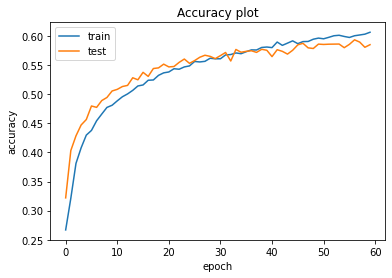

In [ ]:
mm_hist = mm_history.history

plt.plot(mm_hist["accuracy"])
plt.plot(mm_hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mixedmodel_accuracy.png")

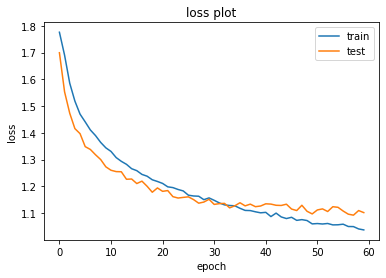

In [ ]:
plt.plot(mm_hist["loss"])
plt.plot(mm_hist["val_loss"])
plt.title("loss plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mixedmodel_loss.png")

Confusion matrix, without normalization
[[ 512    3   65   75  123  140   40]
 [  44   30    6    7    8   13    3]
 [ 160    6  229   80  153  237  159]
 [  59    0   19 1493   94   67   42]
 [  94    1   48  143  710  189   48]
 [ 163    1   99  107  252  580   45]
 [  29    1   44   56   34   21  646]]


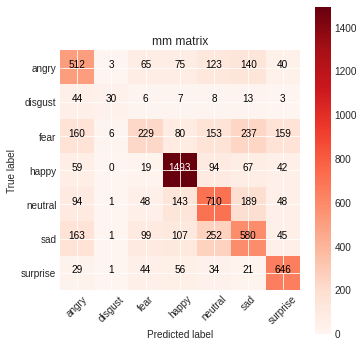

In [ ]:
predictions = mixed_model.predict(final_test_data_gen)
predictions = tf.argmax(predictions, axis = 1).numpy()
cm = confusion_matrix(test_data_gen.classes, predictions)
plot_confusion_matrix(cm, labels.keys(),
                        normalize=False,
                        title='mm matrix',
                        cmap='Reds')

In [ ]:
mm_history2 = mixed_model.fit(train_data_gen, validation_data = test_data_gen, callbacks= [model_checkpoint], epochs = 20)

Epoch 1/20
225/225 [==============================] - 36s 160ms/step - loss: 0.8388 - accuracy: 0.6851 - val_loss: 1.1006 - val_accuracy: 0.6205
Epoch 2/20
225/225 [==============================] - 35s 154ms/step - loss: 0.8358 - accuracy: 0.6879 - val_loss: 1.1012 - val_accuracy: 0.6124
Epoch 3/20
225/225 [==============================] - 34s 153ms/step - loss: 0.8401 - accuracy: 0.6835 - val_loss: 1.0944 - val_accuracy: 0.6180
Epoch 4/20
225/225 [==============================] - 35s 154ms/step - loss: 0.8358 - accuracy: 0.6862 - val_loss: 1.0930 - val_accuracy: 0.6208
Epoch 5/20
225/225 [==============================] - 36s 160ms/step - loss: 0.8340 - accuracy: 0.6866 - val_loss: 1.0983 - val_accuracy: 0.6179
Epoch 6/20
225/225 [==============================] - 34s 153ms/step - loss: 0.8397 - accuracy: 0.6856 - val_loss: 1.0837 - val_accuracy: 0.6198
Epoch 7/20
225/225 [==============================] - 35s 154ms/step - loss: 0.8326 - accuracy: 0.6889 - val_loss: 1.0913 - val_ac

## Vgg19 base mixed model

In [ ]:
pretrained_vgg19_base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(48, 48, 3),
    include_top=False)
pretrained_vgg19_base_model.trainable = False

inputs = tf.keras.Input(shape=(48, 48, 3))
inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
x = pretrained_vgg19_base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Reshape((-1,512))(x)
x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(7)(x)
outputs = tf.keras.layers.Activation('softmax')(x)
pretrained_vgg19_model = tf.keras.Model(inputs, outputs)

pretrained_vgg19_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
mm_vgg_history = pretrained_vgg19_model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 30)

In [ ]:
pretrained_vgg19_base_model.trainable = True


pretrained_vgg19_model.summary()
pretrained_vgg19_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
hh_vgg_history2 = pretrained_vgg19_model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 30)

In [ ]:
#pretrained_vgg19_base_model.trainable = True


pretrained_vgg19_model.summary()
pretrained_vgg19_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
hh_vgg_history2 = pretrained_vgg19_model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 30)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d_18  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 reshape_14 (Reshape)        (None, 1, 512)            0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                147712    
                                                          

KeyboardInterrupt: ignored

# Feature extraction

In [ ]:
import cv2
import numpy as np 
imput_img = 'train/angry/Training_10118481.jpg'
ori = cv2.imread(imput_img)
image = cv2.imread(imput_img)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)

In [ ]:
for f in os.listdir('train'):
  path = os.path.join('train', f)
  for img in os.listdir(path):
    end = len(img) - 4
    img_path = os.path.join(path, img[:end] + 'H.jpg')
    i = cv.imread(os.path.join(path,img))
    gray = np.float32(cv.cvtColor(i,cv.COLOR_BGR2GRAY))
    dst = cv.cornerHarris(gray,2,3,0.04)
    cv.imwrite(img_path, dst)

In [ ]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 48
IMG_WIDTH = 48

train_dir = 'train'
test_dir = 'test'

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=test_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))
final_test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=test_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), shuffle = False)

Found 57418 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Light weight model

In [ ]:
model = tf.keras.Sequential([
    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(32, (5, 5), activation="relu", input_shape=(IMG_WIDTH, IMG_WIDTH, 3)),

    # Max-pooling layer, using 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (7, 7), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        100416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 2304)              0

# Mixed Lightweight model

In [ ]:
mixed_model = tf.keras.Sequential([
    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(32, (5, 5), activation="relu", input_shape=(IMG_WIDTH, IMG_WIDTH, 3)),

    # Max-pooling layer, using 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Reshape((-1, 22, 22, 32)),
    tf.keras.layers.ConvLSTM2D(32, kernel_size = (3,3)),
    tf.keras.layers.Dropout(.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Dropout(.3),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")])

mixed_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
mixed_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 44, 44, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 reshape (Reshape)           (None, 1, 22, 22, 32)     0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 20, 20, 32)        73856     
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 64)        18496     
                                                      

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/final/fe/mm/save.h5',save_freq='epoch',monitor = 'val_accuracy', mode = 'max',save_best_only = True,save_weights_only=False)
hist = model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 60)

Epoch 1/60
449/449 [==============================] - 73s 138ms/step - loss: 1.8094 - accuracy: 0.2546 - val_loss: 1.8084 - val_accuracy: 0.2549
Epoch 2/60
449/449 [==============================] - 60s 133ms/step - loss: 1.7462 - accuracy: 0.2901 - val_loss: 1.6462 - val_accuracy: 0.3351
Epoch 3/60
449/449 [==============================] - 61s 137ms/step - loss: 1.6525 - accuracy: 0.3414 - val_loss: 1.4959 - val_accuracy: 0.4203
Epoch 4/60
449/449 [==============================] - 60s 134ms/step - loss: 1.5840 - accuracy: 0.3779 - val_loss: 1.4066 - val_accuracy: 0.4592
Epoch 5/60
449/449 [==============================] - 62s 137ms/step - loss: 1.5396 - accuracy: 0.3983 - val_loss: 1.3686 - val_accuracy: 0.4666
Epoch 6/60
449/449 [==============================] - 61s 136ms/step - loss: 1.5069 - accuracy: 0.4108 - val_loss: 1.3515 - val_accuracy: 0.4884
Epoch 7/60
449/449 [==============================] - 60s 134ms/step - loss: 1.4786 - accuracy: 0.4231 - val_loss: 1.2937 - val_ac

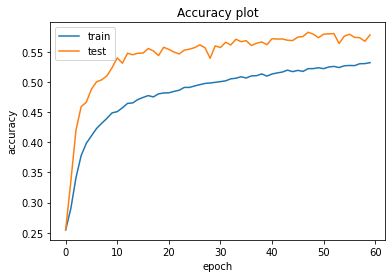

In [ ]:
hist_l = hist.history

plt.plot(hist_l["accuracy"])
plt.plot(hist_l["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("fe_lw_mixed_accuracy.png")

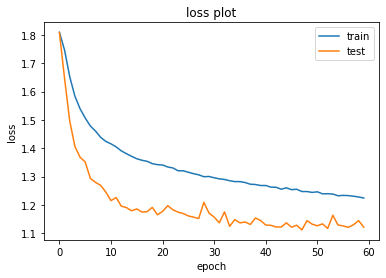

In [ ]:
hist_l = hist.history

plt.plot(hist_l["loss"])
plt.plot(hist_l["val_loss"])
plt.title("loss plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("fe_lw_mixed_loss.png")

In [ ]:
hist2 = model.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint], epochs = 60)

Epoch 1/60
449/449 [==============================] - 58s 129ms/step - loss: 1.2270 - accuracy: 0.5291 - val_loss: 1.1199 - val_accuracy: 0.5755
Epoch 2/60
449/449 [==============================] - 60s 133ms/step - loss: 1.2185 - accuracy: 0.5333 - val_loss: 1.1409 - val_accuracy: 0.5784
Epoch 3/60
449/449 [==============================] - 58s 129ms/step - loss: 1.2206 - accuracy: 0.5329 - val_loss: 1.1412 - val_accuracy: 0.5777
Epoch 4/60
449/449 [==============================] - 60s 134ms/step - loss: 1.2166 - accuracy: 0.5351 - val_loss: 1.1177 - val_accuracy: 0.5795
Epoch 5/60
449/449 [==============================] - 58s 130ms/step - loss: 1.2184 - accuracy: 0.5353 - val_loss: 1.1468 - val_accuracy: 0.5736
Epoch 6/60
449/449 [==============================] - 60s 133ms/step - loss: 1.2188 - accuracy: 0.5322 - val_loss: 1.1328 - val_accuracy: 0.5723
Epoch 7/60
449/449 [==============================] - 60s 133ms/step - loss: 1.2129 - accuracy: 0.5356 - val_loss: 1.1154 - val_ac

# Vgg 19 base

In [ ]:
pretrained_vgg19_base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(48, 48, 3),
    include_top=False)
pretrained_vgg19_base_model.trainable = False

inputs = tf.keras.Input(shape=(48, 48, 3))
inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
x = pretrained_vgg19_base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(6)(x)
outputs = tf.keras.layers.Activation('softmax')(x)
pretrained_vgg19_model = tf.keras.Model(inputs, outputs)

pretrained_vgg19_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
pretrained_vgg19_base_model.trainable = True


pretrained_vgg19_model.summary()
pretrained_vgg19_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model_checkpoint_2 =tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/final/fe/vgg19_mm/2/save.h5',save_freq='epoch',monitor = 'val_accuracy', mode = 'max',save_best_only = True,save_weights_only=False)
hh_vgg_history2 = b.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint_2], epochs = 30)

# Mixed vgg19 base

In [ ]:
pretrained_vgg19_base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(48, 48, 3),
    include_top=False)
pretrained_vgg19_base_model.trainable = False

inputs = tf.keras.Input(shape=(48, 48, 3))
inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
x = pretrained_vgg19_base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Reshape((-1,512))(x)
x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(6)(x)
outputs = tf.keras.layers.Activation('softmax')(x)
pretrained_vgg19_model = tf.keras.Model(inputs, outputs)

pretrained_vgg19_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
pretrained_vgg19_base_model.trainable = True


pretrained_vgg19_model.summary()
b.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model_checkpoint_2 =tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/peter/final/fe/vgg19_mm/2/save.h5',save_freq='epoch',monitor = 'val_accuracy', mode = 'max',save_best_only = True,save_weights_only=False)
hh_vgg_history2 = b.fit(train_data_gen, validation_data = test_data_gen, callbacks = [model_checkpoint_2], epochs = 30)

# Testing model against pictures from web

--2022-08-18 08:29:44--  https://www.houseofwellness.com.au/wp-content/uploads/2018/06/smile-GettyImages-882495390-crop.jpg
Resolving www.houseofwellness.com.au (www.houseofwellness.com.au)... 172.64.149.69, 104.18.38.187, 2606:4700:4400::6812:26bb, ...
Connecting to www.houseofwellness.com.au (www.houseofwellness.com.au)|172.64.149.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99675 (97K) [image/jpeg]
Saving to: ‘test1.jpg’

test1.jpg           100%[===================>]  97.34K  --.-KB/s    in 0.01s   

2022-08-18 08:29:45 (9.31 MB/s) - ‘test1.jpg’ saved [99675/99675]

happy


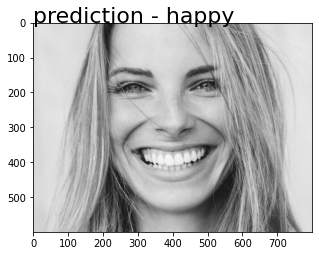

In [ ]:
! wget https://www.houseofwellness.com.au/wp-content/uploads/2018/06/smile-GettyImages-882495390-crop.jpg -O test1.jpg

input_img = 'test1.jpg'
image = cv.imread(input_img, cv.IMREAD_GRAYSCALE)
img = cv.resize(image, (48,48))
a = np.stack((img,)*3, axis = -1)
final = np.expand_dims(a, axis = 0)
res = model.predict(final)
pred = list(train_data_gen.class_indices.keys())[np.argmax(res[0])]
print(pred)

plt.figure(figsize=(5,5))
plt.style.use('grayscale')
plt.grid(visible = None)
plt.imshow(image)
plt.text(0, 0, f'prediction - {pred}', fontsize = 22)
plt.savefig('t1')

--2022-08-17 01:15:36--  https://assets.ldscdn.org/fc/e1/fce19521492419b2ead37877b6e6c0103a6cf627/boy_sad.jpeg
Resolving assets.ldscdn.org (assets.ldscdn.org)... 23.54.56.176, 2600:1413:b000:287::14b3, 2600:1413:b000:281::14b3
Connecting to assets.ldscdn.org (assets.ldscdn.org)|23.54.56.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278101 (272K) [image/jpeg]
Saving to: ‘test2.jpg’

test2.jpg           100%[===================>] 271.58K  --.-KB/s    in 0.007s  

2022-08-17 01:15:36 (36.9 MB/s) - ‘test2.jpg’ saved [278101/278101]

sad


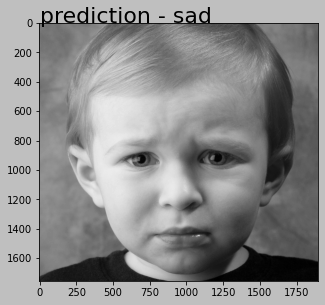

In [ ]:
!wget https://assets.ldscdn.org/fc/e1/fce19521492419b2ead37877b6e6c0103a6cf627/boy_sad.jpeg -O test2.jpg

input_img = 'test2.jpg'
image = cv.imread(input_img, cv.IMREAD_GRAYSCALE)
img = cv.resize(image, (48,48))
a = np.stack((img,)*3, axis = -1)
final = np.expand_dims(a, axis = 0)
res = model.predict(final)
pred = list(train_data_gen.class_indices.keys())[np.argmax(res[0])]
print(pred)

plt.figure(figsize=(5,5))
plt.style.use('grayscale')
plt.grid(visible = None)
plt.imshow(image)
plt.text(0, 0, f'prediction - {pred}', fontsize = 22)
plt.savefig('t2')

--2022-08-18 08:40:49--  https://i.pinimg.com/236x/02/6b/a9/026ba961f0860a6d6578a54b2b6a3a26--expression-facial-facial-expressions.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.96.163.211, 104.96.163.196, 2a04:4e42:5::84
Connecting to i.pinimg.com (i.pinimg.com)|104.96.163.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9893 (9.7K) [image/jpeg]
Saving to: ‘test3.jpg’

test3.jpg           100%[===================>]   9.66K  --.-KB/s    in 0s      

2022-08-18 08:40:49 (118 MB/s) - ‘test3.jpg’ saved [9893/9893]

sad


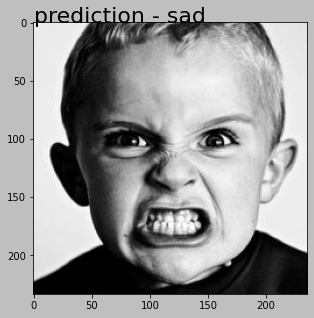

In [ ]:
!wget https://i.pinimg.com/236x/02/6b/a9/026ba961f0860a6d6578a54b2b6a3a26--expression-facial-facial-expressions.jpg -O test3.jpg

input_img = 'test3.jpg'
image = cv.imread(input_img, cv.IMREAD_GRAYSCALE)
img = cv.resize(image, (48,48))
a = np.stack((img,)*3, axis = -1)
final = np.expand_dims(a, axis = 0)
res = model.predict(final)
pred = list(train_data_gen.class_indices.keys())[np.argmax(res[0])]
print(pred)

plt.figure(figsize=(5,5))
plt.style.use('grayscale')
plt.grid(visible = None)
plt.imshow(image)
plt.text(0, 0, f'prediction - {pred}', fontsize = 22)
plt.savefig('t3')

--2022-08-17 01:16:02--  https://www.usameme.com/wp-content/uploads/2022/03/disgusted-face-meme-usameme-2.jpg
Resolving www.usameme.com (www.usameme.com)... 104.21.95.129, 172.67.144.247, 2606:4700:3037::6815:5f81, ...
Connecting to www.usameme.com (www.usameme.com)|104.21.95.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test4.jpg’

test4.jpg               [ <=>                ]   5.46K  --.-KB/s    in 0s      

2022-08-17 01:16:02 (56.3 MB/s) - ‘test4.jpg’ saved [5586]

surprise


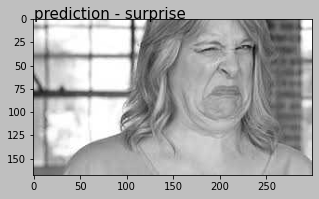

In [ ]:
!wget https://www.usameme.com/wp-content/uploads/2022/03/disgusted-face-meme-usameme-2.jpg -O test4.jpg

input_img = 'test4.jpg'
image = cv.imread(input_img, cv.IMREAD_GRAYSCALE)
img = cv.resize(image, (48,48))
a = np.stack((img,)*3, axis = -1)
final = np.expand_dims(a, axis = 0)
res = model.predict(final)
pred = list(train_data_gen.class_indices.keys())[np.argmax(res[0])]
print(pred)

plt.figure(figsize=(5,5))
plt.style.use('grayscale')
plt.grid(visible = None)
plt.imshow(image)
plt.text(0, 0, f'prediction - {pred}', fontsize = 15)
plt.savefig('t4')

--2022-08-18 08:49:14--  https://st4.depositphotos.com/39241718/40239/i/450/depositphotos_402394384-stock-photo-surprise-concept-portrait-astonished-beautiful.jpg
Resolving st4.depositphotos.com (st4.depositphotos.com)... 104.86.228.187
Connecting to st4.depositphotos.com (st4.depositphotos.com)|104.86.228.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17002 (17K) [image/jpeg]
Saving to: ‘test5.jpg’

test5.jpg           100%[===================>]  16.60K  --.-KB/s    in 0s      

2022-08-18 08:49:15 (139 MB/s) - ‘test5.jpg’ saved [17002/17002]

surprise


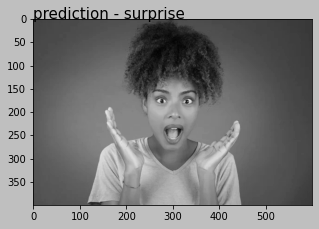

In [ ]:
!wget https://st4.depositphotos.com/39241718/40239/i/450/depositphotos_402394384-stock-photo-surprise-concept-portrait-astonished-beautiful.jpg -O test5.jpg

input_img = 'test5.jpg'
image = cv.imread(input_img, cv.IMREAD_GRAYSCALE)
img = cv.resize(image, (48,48))
a = np.stack((img,)*3, axis = -1)
final = np.expand_dims(a, axis = 0)
res = model.predict(final)
pred = list(train_data_gen.class_indices.keys())[np.argmax(res[0])]
print(pred)

plt.figure(figsize=(5,5))
plt.style.use('grayscale')
plt.grid(visible = None)
plt.imshow(image)
plt.text(0, 0, f'prediction - {pred}', fontsize = 15)
plt.savefig('t5')

--2022-08-18 08:40:10--  https://cdn.mos.cms.futurecdn.net/DMUbjq2UjJcG3umGv3Qjjd.jpeg
Resolving cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)... 8.253.231.250, 204.160.103.250, 8.240.191.250
Connecting to cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)|8.253.231.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108735 (106K) [image/jpeg]
Saving to: ‘test6.jpg’

test6.jpg           100%[===================>] 106.19K  --.-KB/s    in 0.007s  

2022-08-18 08:40:10 (15.2 MB/s) - ‘test6.jpg’ saved [108735/108735]

angry


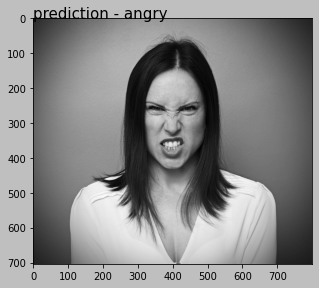

In [ ]:
!wget https://cdn.mos.cms.futurecdn.net/DMUbjq2UjJcG3umGv3Qjjd.jpeg -O test6.jpg

input_img = 'test6.jpg'
image = cv.imread(input_img, cv.IMREAD_GRAYSCALE)
img = cv.resize(image, (48,48))
a = np.stack((img,)*3, axis = -1)
final = np.expand_dims(a, axis = 0)
res = model.predict(final)
pred = list(train_data_gen.class_indices.keys())[np.argmax(res[0])]
print(pred)

plt.figure(figsize=(5,5))
plt.style.use('grayscale')
plt.grid(visible = None)
plt.imshow(image)
plt.text(0, 0, f'prediction - {pred}', fontsize = 15)
plt.savefig('t6')